In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from visualisation import compute_pattern

In [3]:
from preprocess import preprocess_global_crises_data
from preprocess import preprocess_mdp_data

# Change the paths of the dataset according to their location
global_crises_dataset_path = '../raw_data/global_crisis_data_country.csv'
maddison_databse_path = '../raw_data/gdp-per-capita-maddison.csv'

# Read the Global Crises Dataset with the 'unicode_escape' encoding to handle special characters
main_data = pd.read_csv(global_crises_dataset_path, encoding='unicode_escape')
GDP_pc = pd.read_csv(maddison_databse_path)

# Preprocess the dataset (explanations in the preprocess.py file)
preprocess_global_crises_data(main_data)
preprocess_mdp_data(GDP_pc)

# 1. Country selection and dataset analysis

In [88]:
#Select a list among those listed above. Change to any desired list defined above.
country_selected = ['USA']

In [89]:
from dataset import concat_dataset
from dataset import dummy_variable

#Create a dataset with the data of the countries of the list
global_data_left = concat_dataset(main_data, GDP_pc, country_selected, 'left', )

# Perform any necessary preprocessing or feature engineering
dummy_variable(global_data_left)

# Display the resulting dataset (here the first 5 rows)
global_data_left.head()

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap,banking_crisis_only,excluded_years,banking_crisis_only_first_year,recovery_only
0,66.0,USA,United States,1800,0.0,NaN,0.0,0,4.462293619,NaN,...,1,2.0,1,0,0.0,6.70,0,0,0,1
1,66.0,USA,United States,1801,0.0,NaN,0.0,0,4.363001745,NaN,...,0,1.3,1,0,0.0,1.44,0,0,0,1
2,66.0,USA,United States,1802,0.0,NaN,0.0,0,4.474272931,NaN,...,0,-15.7,1,0,0.0,-0.11,0,0,0,1
3,66.0,USA,United States,1803,0.0,NaN,0.0,0,4.662004662,NaN,...,0,5.4,1,0,0.0,-2.87,0,0,0,1
4,66.0,USA,United States,1804,0.0,NaN,0.0,0,4.528985507,NaN,...,0,4.4,1,0,0.0,-3.11,0,0,0,1


## Extraction of the inflation series


In [90]:
from extraction_method_1 import extract_inflation_series
from extraction_method_1 import normalize_serie

inflation_series = extract_inflation_series(global_data_left)
norm_inflation_series = normalize_serie(inflation_series)

In [91]:
# Create a dataset with the data of the countries of the list countries_selected
global_data_inner = concat_dataset(main_data, GDP_pc, country_selected, 'inner')

# Perform any necessary preprocessing or feature engineering
dummy_variable(global_data_inner)

# Display the resulting dataset (here the first 5 rows)
global_data_inner.head()

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap,banking_crisis_only,excluded_years,banking_crisis_only_first_year,recovery_only
0,66.0,USA,United States,1800,0.0,NaN,0.0,0,4.462293619,NaN,...,1,2.0,1,0,0.0,6.70,0,0,0,1
1,66.0,USA,United States,1801,0.0,NaN,0.0,0,4.363001745,NaN,...,0,1.3,1,0,0.0,1.44,0,0,0,1
2,66.0,USA,United States,1802,0.0,NaN,0.0,0,4.474272931,NaN,...,0,-15.7,1,0,0.0,-0.11,0,0,0,1
3,66.0,USA,United States,1803,0.0,NaN,0.0,0,4.662004662,NaN,...,0,5.4,1,0,0.0,-2.87,0,0,0,1
4,66.0,USA,United States,1804,0.0,NaN,0.0,0,4.528985507,NaN,...,0,4.4,1,0,0.0,-3.11,0,0,0,1


We compute a list containing the duration of all the crisis events of the dataset (`crisis_duration_inner`) and a table showing the number of crisis events for each length.  

## Extraction of the output gap series

Now, this cell extracts the inflation series from the `global_data_inner` dataset using the `extract_output_gap_series` function from the `extraction_method_1` module and then store the result in the list `output_gap_series`.

In [92]:
from extraction_method_1 import extract_output_gap_series

output_gap_series = extract_output_gap_series(global_data_inner)

In [93]:
def compute_recovery_duration(data):
    # Get the fist years of each banking crisis
    banking_crisis_only_first_years = data[data['banking_crisis_only_first_year'] == 1]['Year'].tolist()

    # Get the last year of each banking_crisis
    consecutive_ones = 0
    last_year = None
    last_year_with_consecutive_one = None

    # Initialize an empty list to store the last years
    banking_crisis_last_year = []

    # Iterate over the rows of the DataFrame
    for index, row in data.iterrows():
        # Check if the "dummy" column has a value of 1
        if row['banking_crisis'] == 1:
            consecutive_ones += 1
            last_year_with_consecutive_one = row['Year']
        else:
            # If consecutive_ones is greater than 0, store the last year
            if consecutive_ones > 0:
                banking_crisis_last_year.append(last_year_with_consecutive_one + 1)
                consecutive_ones = 0

        # Update the last year
        last_year = row['Year']

    # If there are consecutive ones at the end of the DataFrame, store the last year
    if consecutive_ones > 0:
        banking_crisis_last_year.append(last_year_with_consecutive_one)

    recovery_durations =  []

    for year_b in banking_crisis_only_first_years:
        closest_inferior_year = max([year_a for year_a in banking_crisis_last_year if year_a <= year_b])
        difference = year_b - closest_inferior_year
        recovery_durations.append(difference)

    return recovery_durations

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_all_crisis_on_recovery(series, recovery_duration, string, country_selected):
    index_inferior_5 = []
    index_5_to_10 = []
    index_superior_10 = []

    for i, length in enumerate(recovery_duration):
        if length < 5:
            index_inferior_5.append(i)
        elif 5 <= length < 10:
            index_5_to_10.append(i)
        else:
            index_superior_10.append(i)

    index_lists = [index_inferior_5, index_5_to_10, index_superior_10]

    for position, index_list in enumerate(index_lists):
        sub_series = []
        for index in index_list:
            sub_series.append(series[index])
        average_pattern, number_of_data_points = compute_pattern(sub_series)
        number_observations = len(sub_series)

        years = [f"ts{k}" if k < 0
                 else f"ts" if k == 0
                 else f"ts+{k}" if 0 < k < i
                 else "te" if k == i
                 else f"te+{k - i}"
                 for k in range(-1, len(average_pattern) - 1)]

        # Plotting
        sns.set_style("whitegrid")
        palette = sns.color_palette(n_colors = 3)
        labels = ['< 5 years', '< 10 years', '>= 10 years']
        sns.lineplot(x=years, y=average_pattern, marker='o', alpha=0.9, label=labels[position], color=palette[position])
        plt.axhline(y=0, color='black', linestyle='dashed', alpha=0.6)

        # Text annotation for number of observations
        plt.text(len(years) - 1, average_pattern[-1], f'{number_observations} obs.', ha='right', va='center')

    # Set title, labels, and limits
    plt.title(f'{string} in banc. crises by recovery time from last crisis in {country_selected}')
    plt.legend(loc='upper left')
    if string == 'Inflation rate':
        plt.ylabel('Annual inflation rate')
    elif string == 'Output gap':
        plt.ylabel('Output gap')
    plt.xlabel('Time in years')
    plt.show()

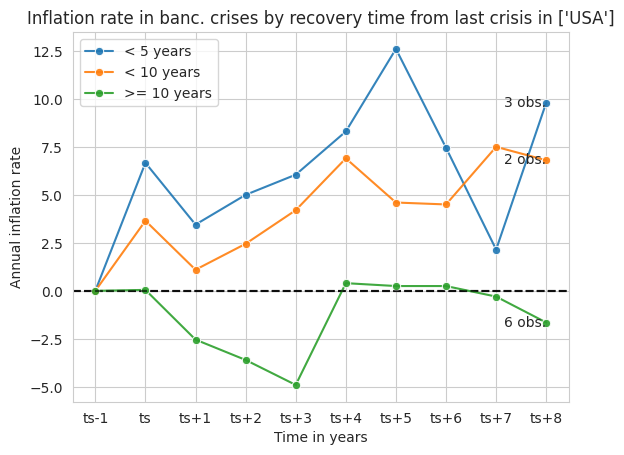

In [95]:
recovery_durations = compute_recovery_duration(global_data_left)
plot_all_crisis_on_recovery(norm_inflation_series, recovery_durations, 'Inflation rate', country_selected)


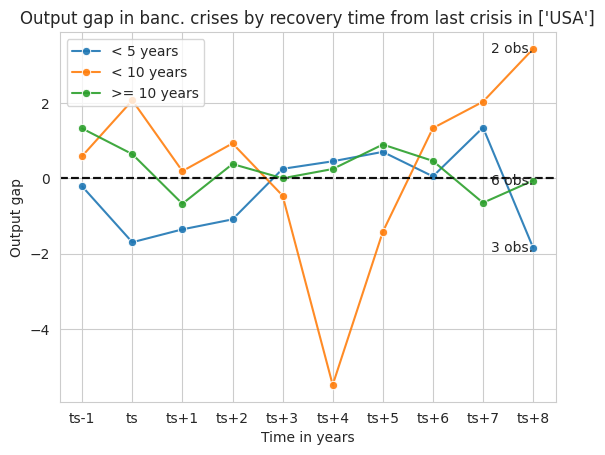

In [96]:
recovery_durations = compute_recovery_duration(global_data_left)
plot_all_crisis_on_recovery(output_gap_series, recovery_durations, 'Output gap', country_selected)